## helper function

In [7]:
import gc
import torch
gc.collect()
del llm
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

NameError: name 'llm' is not defined

In [8]:
import json
import re

def save_to_jsonl(task_ids, outputs, file_path):
    with open(file_path, "w") as f:
        for task_id, output in zip(task_ids, outputs):
            json.dump({
                "task_id": task_id,
                "output": output.strip()
            }, f)
            f.write("\n")
            
def extract_chat_from_ds(example):
    instruction = example.get("instruction", "")
    input_text = example.get("input", "")
    return [{
        "role": "user",
        "content": instruction + "\nYou should only output code, and no explanation.\n" + input_text,
    }]

def extract_code_only(text):
    match = re.search(r"```(?:python)?\n(.+?)```", text, re.DOTALL)
    if match:
        return match.group(1).strip()
    return text.strip()

def append_to_jsonl(task_id, output, file_path):
    with open(file_path, "a", encoding="utf-8") as f:
        json.dump({
            "task_id": task_id,
            "output": extract_code_only(str(output))
        }, f, ensure_ascii=False)
        f.write("\n")

## ngram

In [4]:
import os
os.environ["VLLM_USE_V1"] = "1"

from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from datasets import load_dataset
import time
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Sampling config (move SD config here if needed)
sampling_params = SamplingParams(temperature=0, top_p=0.95, ignore_eos=False, max_tokens=4096)

max_model_len, tp_size = 8192, 1
model_name = "deepseek-ai/DeepSeek-V2-Lite-Chat"
tokenizer = AutoTokenizer.from_pretrained(model_name)

llm = LLM(
    model=model_name, 
    tensor_parallel_size=tp_size, 
    max_model_len=max_model_len, 
    trust_remote_code=True, 
    enforce_eager=True,
    speculative_config={
        "method": "ngram",
        "num_speculative_tokens": 5,
        "prompt_lookup_max": 4,
    },
)

# Dataset
dataset = load_dataset("json", data_files="edit_eval/edit_eval.jsonl", split="train")
messages_list = [extract_chat_from_ds(ex) for ex in dataset]

# Tokenize for vLLM
prompt_token_ids = [
    tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")[0].tolist()
    for messages in messages_list
]

print("\nFirst 10 prompts (decoded):\n")
for i in range(10):
    decoded_prompt = tokenizer.decode(prompt_token_ids[i], skip_special_tokens=True)
    print(f"[{i+1}] {decoded_prompt}\n{'-'*50}")

# Run generation
import csv
with open("expert_routing.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['start'])
start_time = time.time()
outputs = llm.generate(prompt_token_ids=prompt_token_ids, sampling_params=sampling_params)
end_time = time.time()
generated_text = [output.outputs[0].text for output in outputs]

elapsed = end_time - start_time
total_tokens = sum(len(output.outputs[0].token_ids) for output in outputs)
print(f"\nTotal new tokens: {total_tokens}")
print(f"Total generation time: {elapsed:.2f} seconds")
print(f"Throughput: {total_tokens / elapsed:.2f} tokens/sec")

for i in range(len(generated_text)):
    append_to_jsonl(dataset[i]["task_id"], [generated_text[i]], f"ngram_outputs.jsonl")

/workspace/vllmenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 05-07 21:43:35 [__init__.py:239] Automatically detected platform cuda.


2025-05-07 21:44:25,113	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
[2025-05-07 21:44:33] INFO config.py:54: PyTorch version 2.7.0 available.


INFO 05-07 21:44:37 [config.py:214] Replacing legacy 'type' key with 'rope_type'
INFO 05-07 21:46:59 [config.py:748] This model supports multiple tasks: {'reward', 'embed', 'generate', 'score', 'classify'}. Defaulting to 'generate'.
WARNING 05-07 21:46:59 [arg_utils.py:1518] Detected VLLM_USE_V1=1 with ngram. Usage should be considered experimental. Please report any issues on Github.
INFO 05-07 21:46:59 [config.py:2053] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 05-07 21:46:59 [cuda.py:93] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 05-07 21:46:59 [cuda.py:157] Forcing kv cache block size to 64 for FlashMLA backend.
WARNING 05-07 21:46:59 [utils.py:2410] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/getting_started/troubleshooting.html#python-multiprocessing for more info

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:04,  1.66s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:03<00:03,  1.75s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:05<00:01,  1.77s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:06<00:00,  1.55s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:06<00:00,  1.62s/it]



INFO 05-07 21:49:36 [loader.py:459] Loading weights took 6.59 seconds
INFO 05-07 21:49:36 [gpu_model_runner.py:1346] Loading drafter model...
INFO 05-07 21:49:37 [gpu_model_runner.py:1353] Model loading took 29.3011 GiB and 7.767866 seconds
WARNING 05-07 21:50:21 [fused_moe.py:668] Using default MoE config. Performance might be sub-optimal! Config file not found at /workspace/vllm/vllm/model_executor/layers/fused_moe/configs/E=64,N=1408,device_name=NVIDIA_H100_80GB_HBM3.json
INFO 05-07 21:50:29 [kv_cache_utils.py:639] GPU KV cache size: 1,289,024 tokens
INFO 05-07 21:50:29 [kv_cache_utils.py:642] Maximum concurrency for 8,192 tokens per request: 157.35x
INFO 05-07 21:50:29 [core.py:161] init engine (profile, create kv cache, warmup model) took 52.73 seconds
INFO 05-07 21:50:29 [core_client.py:442] Core engine process 0 ready.

First 10 prompts (decoded):

[1] User: Change the function so that it checks if all numbers are within the threshold distance with a tolerance of 1e-5 from the s

Processed prompts: 100%|██████████| 194/194 [02:45<00:00,  1.18it/s, est. speed input: 150.15 toks/s, output: 120.55 toks/s]



Total new tokens: 19898
Total generation time: 165.11 seconds
Throughput: 120.51 tokens/sec


In [ ]:
import csv
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter()
with open("expert_routing_ngram.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        experts = map(int, row)
        counter.update(experts)

expert_ids = sorted(counter.keys())
counts = [counter[eid]/27 for eid in expert_ids]

plt.figure(figsize=(15, 6))
plt.bar(expert_ids, counts)
plt.xlabel("Expert ID")
plt.ylabel("Number of Times Routed")
plt.title("Routing Frequency of Each Expert")
plt.xticks(expert_ids)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


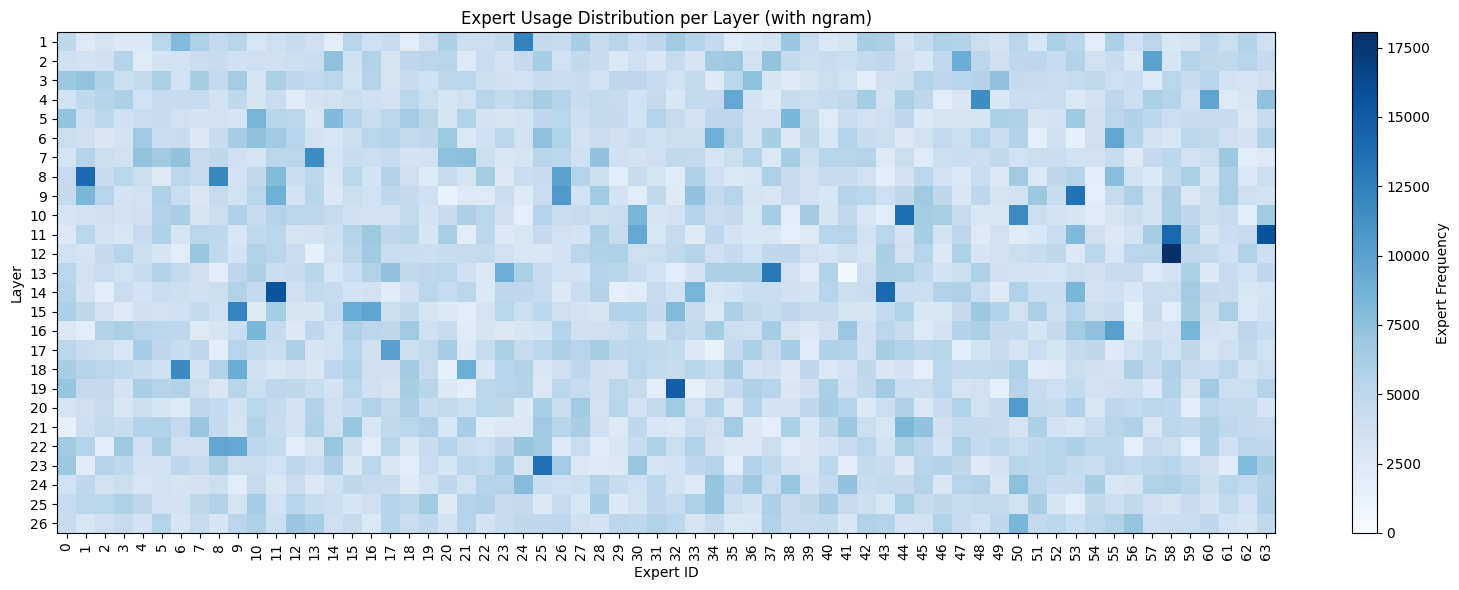

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

file_path = "expert_routing_ngram.csv"

with open(file_path, 'r') as f:
    lines = f.read().splitlines()

layer_expert_map = defaultdict(list)
current_layer = None

for line in lines:
    if ',' not in line:
        current_layer = int(line)
    else:
        experts = [int(e.strip()) for e in line.split(',')]
        layer_expert_map[current_layer].extend(experts)

df = pd.DataFrame([
    {'layer': layer, 'expert': expert}
    for layer, experts in layer_expert_map.items()
    for expert in experts
])

count_df_ngram = df.groupby(['layer', 'expert']).size().unstack(fill_value=0).sort_index()

vmax = count_df_ngram.values.max()
vmin = 0

plt.figure(figsize=(16, 6))
plt.imshow(count_df_ngram, aspect='auto', cmap='Blues', vmin=vmin, vmax=vmax)
plt.colorbar(label='Expert Frequency')
plt.xlabel("Expert ID")
plt.ylabel("Layer")
plt.title("Expert Usage Distribution per Layer (with ngram)")
plt.xticks(ticks=range(len(count_df_ngram.columns)), labels=count_df_ngram.columns, rotation=90)
plt.yticks(ticks=range(len(count_df_ngram.index)), labels=count_df_ngram.index)
plt.tight_layout()
plt.show()


## without ngram

In [ ]:
import os
os.environ["VLLM_USE_V1"] = "1"

from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from datasets import load_dataset
import time
import random
import numpy as np
import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

# Sampling config (move SD config here if needed)
sampling_params = SamplingParams(temperature=0, top_p=0.95, ignore_eos=False, max_tokens=4096)

max_model_len, tp_size = 8192, 1
model_name = "deepseek-ai/DeepSeek-V2-Lite-Chat"
tokenizer = AutoTokenizer.from_pretrained(model_name)

llm = LLM(
    model=model_name, 
    tensor_parallel_size=tp_size, 
    max_model_len=max_model_len, 
    trust_remote_code=True, 
    enforce_eager=True,
)

import csv
with open("expert_routing.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['start'])

# Dataset
dataset = load_dataset("json", data_files="edit_eval/edit_eval.jsonl", split="train")
messages_list = [extract_chat_from_ds(ex) for ex in dataset]

# Tokenize for vLLM
prompt_token_ids = [
    tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")[0].tolist()
    for messages in messages_list
]

print("\nFirst 10 prompts (decoded):\n")
for i in range(10):
    decoded_prompt = tokenizer.decode(prompt_token_ids[i], skip_special_tokens=True)
    print(f"[{i+1}] {decoded_prompt}\n{'-'*50}")

# Run generation
start_time = time.time()
outputs = llm.generate(prompt_token_ids=prompt_token_ids, sampling_params=sampling_params)
end_time = time.time()
generated_text = [output.outputs[0].text for output in outputs]

elapsed = end_time - start_time
total_tokens = sum(len(output.outputs[0].token_ids) for output in outputs)
print(f"\nTotal new tokens: {total_tokens}")
print(f"Total generation time: {elapsed:.2f} seconds")
print(f"Throughput: {total_tokens / elapsed:.2f} tokens/sec")

for i in range(len(generated_text)):
    append_to_jsonl(dataset[i]["task_id"], [generated_text[i]], f"nongram_outputs.jsonl")

INFO 05-07 22:05:27 [config.py:214] Replacing legacy 'type' key with 'rope_type'
INFO 05-07 22:05:27 [config.py:748] This model supports multiple tasks: {'reward', 'embed', 'generate', 'score', 'classify'}. Defaulting to 'generate'.
INFO 05-07 22:05:27 [config.py:2053] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 05-07 22:05:27 [cuda.py:93] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 05-07 22:05:27 [cuda.py:157] Forcing kv cache block size to 64 for FlashMLA backend.
INFO 05-07 22:07:12 [__init__.py:239] Automatically detected platform cuda.
INFO 05-07 22:07:56 [core.py:59] Initializing a V1 LLM engine (v0.8.5.dev442+g9352cdb56.d20250507) with config: model='deepseek-ai/DeepSeek-V2-Lite-Chat', speculative_config=None, tokenizer='deepseek-ai/DeepSeek-V2-Lite-Chat', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revis

Loading safetensors checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading safetensors checkpoint shards:  25% Completed | 1/4 [00:01<00:04,  1.60s/it]
Loading safetensors checkpoint shards:  50% Completed | 2/4 [00:03<00:03,  1.68s/it]
Loading safetensors checkpoint shards:  75% Completed | 3/4 [00:05<00:01,  1.68s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:06<00:00,  1.43s/it]
Loading safetensors checkpoint shards: 100% Completed | 4/4 [00:06<00:00,  1.52s/it]



INFO 05-07 22:08:12 [loader.py:459] Loading weights took 6.18 seconds
INFO 05-07 22:08:12 [gpu_model_runner.py:1353] Model loading took 29.3011 GiB and 7.290843 seconds
WARNING 05-07 22:08:50 [fused_moe.py:668] Using default MoE config. Performance might be sub-optimal! Config file not found at /workspace/vllm/vllm/model_executor/layers/fused_moe/configs/E=64,N=1408,device_name=NVIDIA_H100_80GB_HBM3.json
INFO 05-07 22:08:51 [kv_cache_utils.py:639] GPU KV cache size: 1,289,024 tokens
INFO 05-07 22:08:51 [kv_cache_utils.py:642] Maximum concurrency for 8,192 tokens per request: 157.35x
INFO 05-07 22:08:51 [core.py:161] init engine (profile, create kv cache, warmup model) took 38.66 seconds
INFO 05-07 22:08:51 [core_client.py:442] Core engine process 0 ready.

First 10 prompts (decoded):

[1] User: Change the function so that it checks if all numbers are within the threshold distance with a tolerance of 1e-5 from the single number before them. 
You should only output code, and no explanati

Processed prompts:  99%|█████████▉| 193/194 [01:42<00:16, 16.50s/it, est. speed input: 240.03 toks/s, output: 194.99 toks/s]

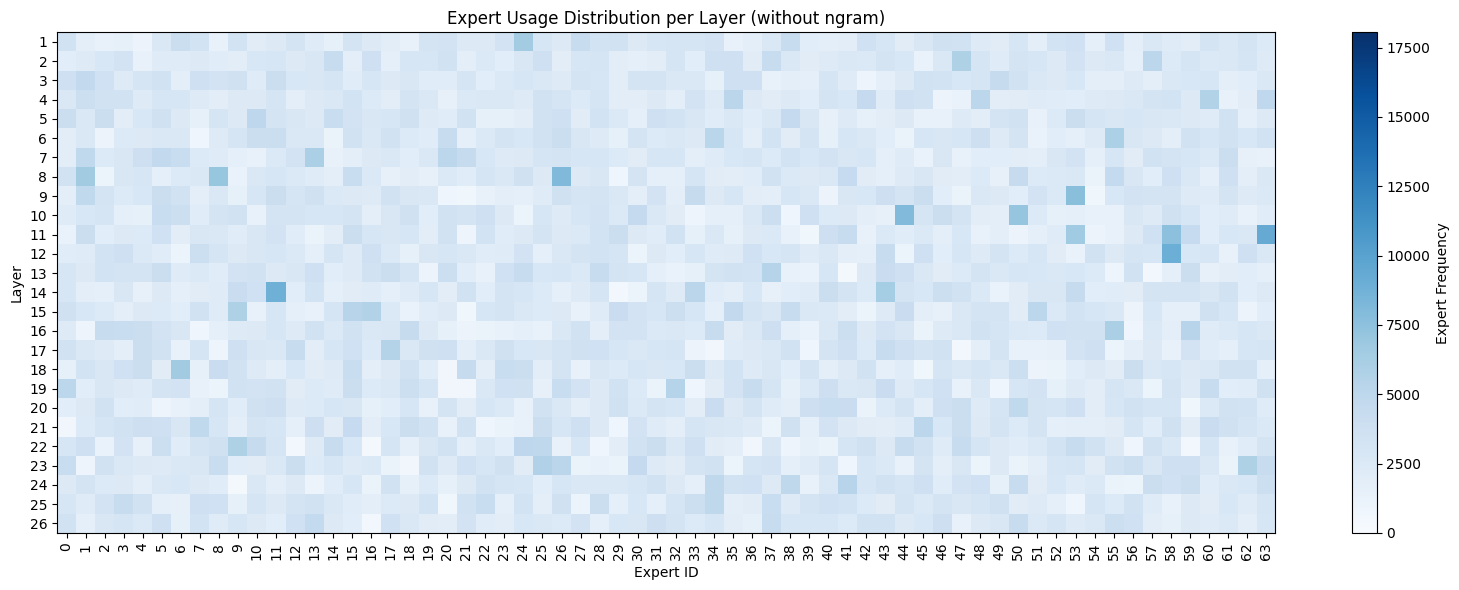

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

file_path = "expert_routing_nongram.csv"

with open(file_path, 'r') as f:
    lines = f.read().splitlines()

layer_expert_map = defaultdict(list)
current_layer = None

for line in lines:
    if ',' not in line:
        current_layer = int(line)
    else:
        experts = [int(e.strip()) for e in line.split(',')]
        layer_expert_map[current_layer].extend(experts)

df = pd.DataFrame([
    {'layer': layer, 'expert': expert}
    for layer, experts in layer_expert_map.items()
    for expert in experts
])

count_df_nongram = df.groupby(['layer', 'expert']).size().unstack(fill_value=0).sort_index()

plt.figure(figsize=(16, 6))
plt.imshow(count_df_nongram, aspect='auto', cmap='Blues', vmin=vmin, vmax=vmax)
plt.colorbar(label='Expert Frequency')
plt.xlabel("Expert ID")
plt.ylabel("Layer")
plt.title("Expert Usage Distribution per Layer (without ngram)")
plt.xticks(ticks=range(len(count_df_nongram.columns)), labels=count_df_nongram.columns, rotation=90)
plt.yticks(ticks=range(len(count_df_nongram.index)), labels=count_df_nongram.index)
plt.tight_layout()
plt.show()


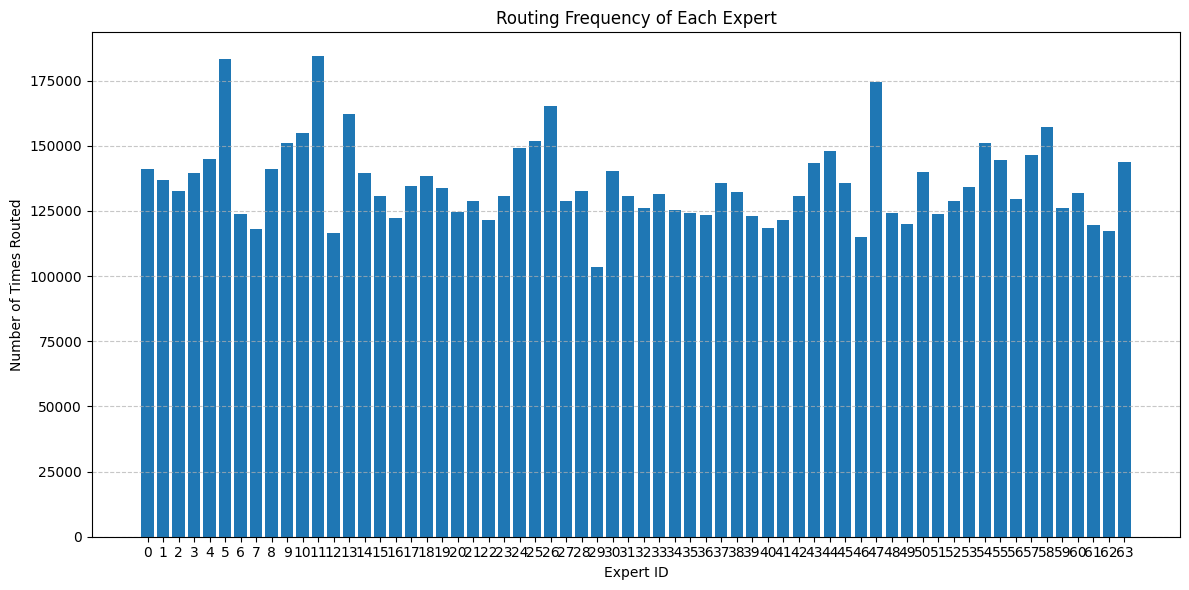

In [5]:
import csv
from collections import Counter
import matplotlib.pyplot as plt

counter = Counter()
with open("inference_expert_nongram.csv", "r") as f:
    reader = csv.reader(f)
    for row in reader:
        experts = map(int, row)
        counter.update(experts)

expert_ids = sorted(counter.keys())
counts = [counter[eid] for eid in expert_ids]

plt.figure(figsize=(12, 6))
plt.bar(expert_ids, counts)
plt.xlabel("Expert ID")
plt.ylabel("Number of Times Routed")
plt.title("Routing Frequency of Each Expert")
plt.xticks(expert_ids)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## eagle

In [ ]:
def save_to_jsonl(task_ids, outputs, file_path):
    with open(file_path, "w") as f:
        for task_id, output in zip(task_ids, outputs):
            json.dump({
                "task_id": task_id,
                "output": output.strip()
            }, f)
            f.write("\n")
            
def extract_chat_from_ds(example):
    instruction = example.get("instruction", "")
    input_text = example.get("input", "")
    return [{
        "role": "user",
        "content": instruction + "\nYou should only output code, and no explanation.\n" + input_text,
    }]

from vllm import LLM, SamplingParams
from transformers import AutoTokenizer
from datasets import load_dataset
import time

# Sampling config (move SD config here if needed)
sampling_params = SamplingParams(temperature=0, top_p=0.95, ignore_eos=False, max_tokens=4096)

max_model_len, tp_size = 8192, 1
model_name = "deepseek-ai/DeepSeek-V2-Lite-Chat"
tokenizer = AutoTokenizer.from_pretrained(model_name)

llm = LLM(
    model=model_name, 
    tensor_parallel_size=tp_size, 
    max_model_len=max_model_len, 
    trust_remote_code=True, 
    enforce_eager=True,
    speculative_config={
        "method": 'eagle',
        "model": 'Momorami/EAGLE-DeepSeek-V2-Lite-Chat-v2',
        "num_speculative_tokens": 5,
        "draft_tensor_parallel_size": 1,
        "max_model_len": max_model_len,
    },
)

# Dataset
ds = load_dataset("AiCloser/sharegpt_cot_dataset", split="train")
messages_list = [extract_chat_from_ds(ex) for ex in dataset]

# Tokenize for vLLM
prompt_token_ids = [
    tokenizer.apply_chat_template(messages, add_generation_prompt=True, return_tensors="pt")[0].tolist()
    for messages in messages_list
]

# Run generation
start_time = time.time()
outputs = llm.generate(prompt_token_ids=prompt_token_ids, sampling_params=sampling_params)
end_time = time.time()
generated_text = [output.outputs[0].text for output in outputs]

elapsed = end_time - start_time
total_tokens = sum(len(output.outputs[0].token_ids) for output in outputs)
print(f"\nTotal new tokens: {total_tokens}")
print(f"Total generation time: {elapsed:.2f} seconds")
print(f"Throughput: {total_tokens / elapsed:.2f} tokens/sec")

for i in range(len(generated_text)):
    append_to_jsonl(dataset[i]["task_id"], [generated_text[i]], f"eagle_outputs.jsonl")

## without eagle